# Testing out different models


## Objectives

We need to now decide which model will be the most appropriate for this task. We have labeled data so we will focus on supervised learning models.

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="https://#LogisticRegression">Logistic Regression</a></li>
        <li><a href="https://#RandomForrest">Random Forrest</a></li>
        <li><a href="https://#XGBoost">XGBoost</a></li>
    </ol>
</div>
<br>
<hr>

### Importing the packages

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns                                       
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix as cm 
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score
from sklearn.tree import export_text
from xgboost import XGBClassifier
from sklearn import metrics
import pandas as pd
import shap

/Users/johannawahn/opt/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),"train Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}

### Data preprocessing

In [36]:
num_vars = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

def input_transform(df_og, impute=True, no_nans = False, drop_cols=[], y=True):
    df = df_og.copy()
    
    if impute:
        ## We replace the missing values by the median of the numerical columns and the log transform
        # to normalize
        df[num_vars] = df[num_vars].apply(lambda col: col.fillna(col.median()), axis=0)
        df[num_vars[1:]] = df[num_vars[1:]].apply(lambda col: np.where(col > 0, np.log(col), col), 
                                                axis=0)
    
        # Everyone under 18 without a VIP status is assigned as non-VIP 
        df.VIP[(df.VIP.isnull()) & (df.Age<18)] = False

    ## We create interaction terms by separating PassengerId and uniting HomePlanet/Destination
    df[['GroupID', 'PartySize']] = df['PassengerId'].str.split('_', expand=True).astype(int)
    df['PartySize'] = df.groupby('GroupID')['PartySize'].transform('max')
    df[['Deck', 'RoomNbr','Side']] = df['Cabin'].str.split('/', expand=True)
    df['Road'] = df['HomePlanet'] + '_' + df['Destination']

    ## We drop all unique identifiers that do not bring any information
    df.drop(['HomePlanet','Destination','PassengerId', 'Name', 'Cabin', 'RoomNbr'], 
            axis=1, inplace=True)
    
    ## We label encode the categorical variables: Deck letter and the new Road variable
    le_Deck = LabelEncoder()
    le_Deck.fit(df.Deck)
    df['Deck'] = le_Deck.transform(df.Deck)
    le_Road = LabelEncoder()
    le_Road.fit(df.Road)
    df['Road'] = le_Road.transform(df.Road)

    ## All the binary categorical variables are transform into binary values
    df['CryoSleep'] = df['CryoSleep'].map({True: 1, False: 0})
    if impute:
        df['VIP'] = df['VIP'].map({True: 1, False: 0}).fillna(0)
    else:
        df['VIP'] = df['VIP'].map({True: 1, False: 0})
    df['Side'] = df['Side'].map({'P': 1, 'S': 0})
    if no_nans:
        df.dropna(inplace=True)
    
    if y:
        drop_cols.append('Transported')
        return(df.drop(drop_cols,axis=1), df.Transported)
    else:
        return(df.drop(drop_cols,axis=1))

In [4]:
df_og = pd.read_csv('train.csv')

In [55]:
df_og.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Logistic Regression

We want to predict a binary value (transported or not)

In [4]:
X,y = input_transform(df_og, no_nans=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

/Users/johannawahn/opt/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/6h/8sfx_lvj7qqcb000hqw9cckw0000gn/T/ipykernel_51003/3248119894.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.VIP[(df.VIP.isnull()) & (df.Age<18)] = False


In [13]:
lr = LogisticRegression()
s = StandardScaler()
p = PolynomialFeatures(degree=3)

estimator = Pipeline([("scaler", s),
                      ("regression", lr)])
clf = estimator.fit(X_train,y_train)
preds = clf.predict(X_test)

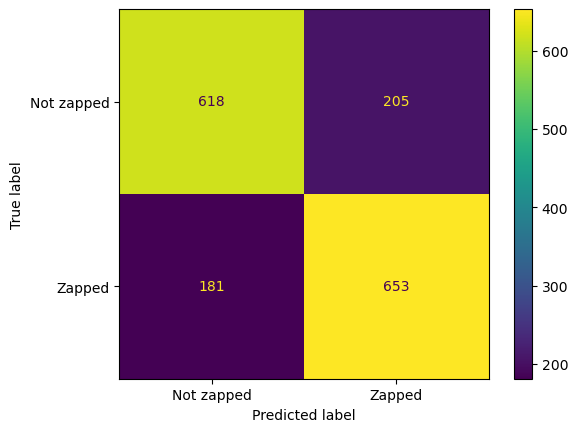

Accuracy: 0.7670488835244418
Precision: 0.7610722610722611


In [6]:
cmatrix = cm(y_test,preds)
ConfusionMatrixDisplay(cmatrix, display_labels = ['Not zapped', 'Zapped']).plot()
plt.show()

print(f'Accuracy: {accuracy_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test,preds)}')


### Let's tune the polynomial degree parameter using cross validation

In [7]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)
scores = []
coefs = []
for polyD in [1,2,3,4,5]:
    lr_ht = LogisticRegression(max_iter=100000)
    p = PolynomialFeatures(degree=polyD)

    estimator = Pipeline([("Poly", p),
                          ("scaler", s),
                          ("regression", lr_ht)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = accuracy_score(y, predictions)
    
    scores.append(score)

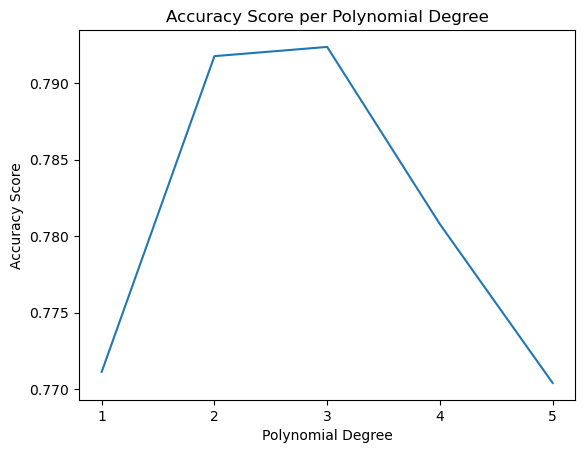

In [8]:
plt.plot(['1','2','3','4','5'], scores)
plt.xlabel('Polynomial Degree')
plt.ylabel('Accuracy Score')
plt.title("Accuracy Score per Polynomial Degree")
plt.show()


Let's train the model again with the degree 3

In [9]:
estimator = Pipeline([("Poly", PolynomialFeatures(degree=3)),
                      ("scaler", s),
                      ("regression", LogisticRegression(max_iter=100000))])
clf = estimator.fit(X_train,y_train)
preds = clf.predict(X_test)

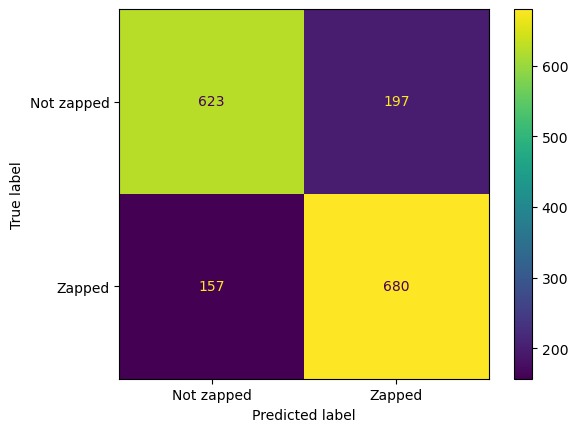

Accuracy: 0.7863608931804466
Precision: 0.7753705815279361


In [108]:
cmatrix = cm(y_test,preds)
ConfusionMatrixDisplay(cmatrix, display_labels = ['Not zapped', 'Zapped']).plot()
plt.show()

print(f'Accuracy: {accuracy_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test,preds)}')

In [149]:
df_importances = pd.DataFrame(zip(clf.named_steps["Poly"].get_feature_names_out(),
                 clf.named_steps["regression"].coef_.flatten(),
))

In [151]:
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))
col_names_dict

{0: 'CryoSleep',
 1: 'Age',
 2: 'VIP',
 3: 'RoomService',
 4: 'FoodCourt',
 5: 'ShoppingMall',
 6: 'Spa',
 7: 'VRDeck',
 8: 'GroupID',
 9: 'PartySize',
 10: 'Deck',
 11: 'Side',
 12: 'Road'}

In [152]:
df_importances.sort_values(by=1)

,0,1
504,VRDeck^3,-1.992794
525,GroupID^3,-1.816933
476,Spa^3,-1.768874
99,Deck^2,-1.667826
559,Road^3,-1.383464
...,...,...
192,CryoSleep Deck Road,1.354376
440,ShoppingMall^3,1.364141
90,GroupID^2,1.564782
528,GroupID^2 Side,1.659715


Increasing the polynomial degree has caused an explosion in number of features. To adress this we'll add some regularization to drop the features that are murking the model's prediction power.

Overall not that good of a result... but not all that terrible! Could have been due to all of the imputations we did.
Let's try regularizing model!

## Regularization

In [14]:
estimator = Pipeline([("Poly", PolynomialFeatures(degree=3)),
                      ("scaler", s),
                      ("regression", LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear'))])
clf = estimator.fit(X_train,y_train)
preds = clf.predict(X_test)

cr = classification_report(y_test, preds)
print(cr)

              precision    recall  f1-score   support

       False       0.81      0.76      0.78       823
        True       0.78      0.82      0.80       834

    accuracy                           0.79      1657
   macro avg       0.79      0.79      0.79      1657
weighted avg       0.79      0.79      0.79      1657



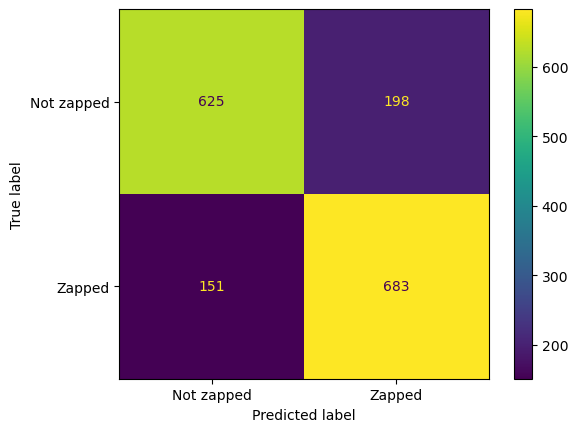

Accuracy: 0.7893783946891973
Precision: 0.775255391600454


In [15]:
cmatrix = cm(y_test,preds)
ConfusionMatrixDisplay(cmatrix, display_labels = ['Not zapped', 'Zapped']).plot()
plt.show()

print(f'Accuracy: {accuracy_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test,preds)}')

We can see a minimal improvement but nothing significant.

# Random Forest

In [16]:
X,y = input_transform(df_og, no_nans=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

/Users/johannawahn/opt/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/6h/8sfx_lvj7qqcb000hqw9cckw0000gn/T/ipykernel_51003/3248119894.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.VIP[(df.VIP.isnull()) & (df.Age<18)] = False


In [23]:

# Step 4: Advanced Model - Random Forest Regressor
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 150, 200, 300, 400],
    'max_depth': [n*5 for n in range(4)],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
 
# Best model
best_rf_model = grid_search.best_estimator_
 
# Predictions
y_pred = best_rf_model.predict(X_test)
 

/Users/johannawahn/opt/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/johannawahn/opt/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/johannawahn/opt/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 341, in fit
    self._validate_params()
  File "/Users/johannawahn/opt/anaconda3/envs/MachineLearning/l

In [24]:
print(get_accuracy(X_train, X_test, y_train, y_test, grid_search.best_estimator_))

{'test Accuracy': 0.8080869040434521, 'train Accuracy': 0.8708314471103064}


In [25]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

       False       0.82      0.79      0.80       829
        True       0.80      0.83      0.81       828

    accuracy                           0.81      1657
   macro avg       0.81      0.81      0.81      1657
weighted avg       0.81      0.81      0.81      1657



Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.81
Precision: 0.80


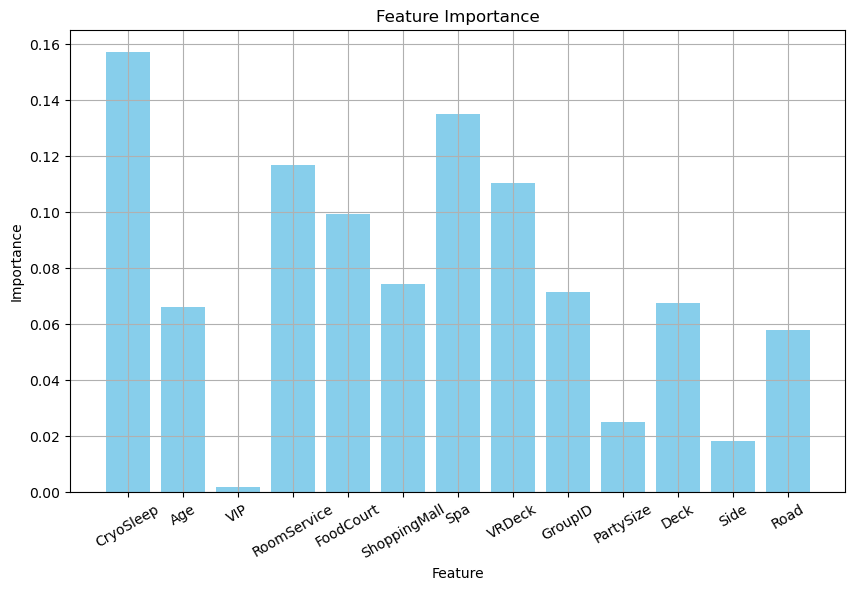

In [26]:
# Evaluation Metrics
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred)
 
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {pre:.2f}")
 
# Step 5: Visualization - Feature Importance
plt.figure(figsize=(10, 6))
feature_importance = best_rf_model.feature_importances_
plt.bar(X.columns, feature_importance, color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.xticks(rotation=30) 
plt.ylabel('Importance')
plt.grid()
plt.show()

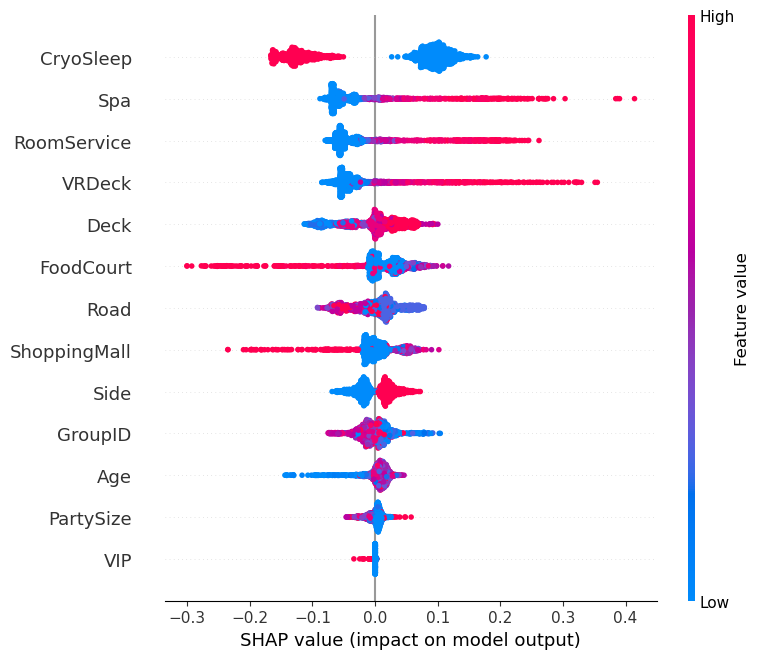

In [27]:
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values[:,:,0], X_test) 
# Dependence Plot (for a key feature, e.g., 'lagged_price')
#shap.dependence_plot("CryoSleep", shap_values, X_test)

In [30]:
tree_exp = export_text(best_rf_model.estimators_[0], feature_names=list(X_train.columns))
print(tree_exp)

|--- ShoppingMall <= 0.35
|   |--- Spa <= 0.90
|   |   |--- FoodCourt <= 0.35
|   |   |   |--- VRDeck <= 0.35
|   |   |   |   |--- Deck <= 5.50
|   |   |   |   |   |--- Deck <= 3.50
|   |   |   |   |   |   |--- Road <= 4.50
|   |   |   |   |   |   |   |--- Age <= 25.50
|   |   |   |   |   |   |   |   |--- GroupID <= 4081.00
|   |   |   |   |   |   |   |   |   |--- Deck <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |--- Deck >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |--- GroupID >  4081.00
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- Age >  25.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- Road >  4.50
|   |   |   |   |   |   |   |--- GroupID <= 12.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- GroupID >  12.50
|   |   |   |   |   |   |   |   |--- Side <= 0.50
|   |   |   

# XGBoost

In [29]:
X,y = input_transform(df_og, no_nans=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

/Users/johannawahn/opt/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/6h/8sfx_lvj7qqcb000hqw9cckw0000gn/T/ipykernel_51974/3248119894.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.VIP[(df.VIP.isnull()) & (df.Age<18)] = False


In [30]:
xgb_model = XGBClassifier(eval_metric='mlogloss', objective='binary:logistic')

param_grid = {
    'n_estimators': [20,30,50,80,100, 150, 200, 300, 400],
    'learning_rate': [0.1, 0.2,0.4,0.6,0.8,0.9,1],
    'max_depth': [n+1 for n in range(6)]
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

In [31]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constrain...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1],
                         'max_depth': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [20, 30, 50, 80, 100, 150, 200, 300,
                                          400]},
             scoring='accuracy')

In [32]:
grid_search.best_params_

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}

In [33]:
# Best model
best_xgb_model = grid_search.best_estimator_
 
# Predictions
y_pred = best_xgb_model.predict(X_test)
print(get_accuracy(X_train, X_test, y_train, y_test, best_xgb_model))

{'test Accuracy': 0.8123114061557031, 'train Accuracy': 0.8844122529047834}


The model seems to be overfitting

In [34]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

       False       0.81      0.81      0.81       818
        True       0.82      0.81      0.81       839

    accuracy                           0.81      1657
   macro avg       0.81      0.81      0.81      1657
weighted avg       0.81      0.81      0.81      1657



100%|██████████| 10/10 [10:59<00:00, 65.98s/it]
/var/folders/6h/8sfx_lvj7qqcb000hqw9cckw0000gn/T/ipykernel_51974/1439921282.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(N_estimators)


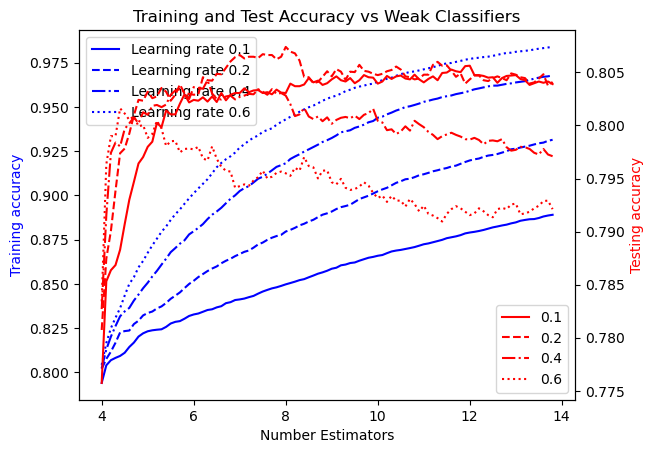

In [14]:
from tqdm import tqdm

def get_accuracy_boost(X,y,title,times=20,xlabel='Number Estimators',Learning_rate_=[0.2,0.4,0.6,1], n_est = 100, objective='binary:logistic'):

    lines_array=['solid','--', '-.', ':']

    N_estimators=[n*2 for n in range(1,n_est//2)]
    
    train_acc=np.zeros((times,len(Learning_rate_),len(N_estimators)))
    test_acc=np.zeros((times,len(Learning_rate_),len(N_estimators)))


    #Iterate through different number of Learning rate  and average out the results  
    
    for n in tqdm(range(times)):
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)
        for n_estimators in N_estimators:
            for j,lr in enumerate(Learning_rate_):


                model = XGBClassifier(objective=objective,learning_rate=lr,n_estimators=n_estimators,eval_metric='mlogloss')


                model.fit(X_train,y_train)



                Accuracy=get_accuracy(X_train, X_test, y_train, y_test,  model)



                train_acc[n,j,(n_estimators//2)-1]=Accuracy['train Accuracy']
                test_acc[n,j,(n_estimators//2)-1]=Accuracy['test Accuracy']
    



    fig, ax1 = plt.subplots()
    mean_test=test_acc.mean(axis=0)
    mean_train=train_acc.mean(axis=0)
    ax2 = ax1.twinx()

    for j,(lr,line) in enumerate(zip(Learning_rate_,lines_array)): 

        ax1.plot(mean_train[j,:],linestyle = line,color='b',label="Learning rate "+str(lr))
        ax2.plot(mean_test[j,:],linestyle = line, color='r',label=str(lr))

    ax1.set_ylabel('Training accuracy',color='b')
    ax1.legend()
    ax2.set_ylabel('Testing accuracy', color='r')
    ax2.legend()
    ax1.set_xlabel(xlabel)
    ax1.set_xticklabels(N_estimators)
    plt.show()

get_accuracy_boost(X,y,title="Training and Test Accuracy vs Weak Classifiers",times=10,xlabel='Number Estimators', n_est = 200, Learning_rate_=[0.1,0.2,0.4,0.6,0.8,0.9,1])

Let's try turning on the imputation during input preprocessing just to see what happens. 

In [15]:
X,y = input_transform(df_og, impute=True, no_nans=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

/Users/johannawahn/opt/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/6h/8sfx_lvj7qqcb000hqw9cckw0000gn/T/ipykernel_51974/3248119894.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.VIP[(df.VIP.isnull()) & (df.Age<18)] = False


In [16]:
xgb_model = XGBClassifier(eval_metric='mlogloss', objective='binary:logistic')

param_grid = {
    'n_estimators': [20,30,50,80,100, 150, 200, 300, 400],
    'learning_rate': [0.1, 0.2,0.4,0.6,0.8,0.9,1],
    'max_depth': [n+1 for n in range(6)]
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constrain...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1],
                         'max_depth': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [20, 30, 50, 80, 100, 150, 200, 300,
                                          400]},
             scoring='accuracy')

In [17]:
grid_search.best_params_

{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300}

In [18]:
# Best model
best_xgb_model = grid_search.best_estimator_
 
# Predictions
y_pred = best_xgb_model.predict(X_test)
print(get_accuracy(X_train, X_test, y_train, y_test, best_xgb_model))

{'test Accuracy': 0.8135184067592034, 'train Accuracy': 0.912328353704542}


The first XGBoost model is the best one out of the three we tried so we will submit this one.

# Submission 

We will be using the `best_xgb_model` to predict the submission 

In [35]:
X_sub = pd.read_csv('test.csv')
X_sub

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [47]:
X = input_transform(X_sub, no_nans=False, y=False)
X.head()

/Users/johannawahn/opt/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/6h/8sfx_lvj7qqcb000hqw9cckw0000gn/T/ipykernel_51974/2197898810.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.VIP[(df.VIP.isnull()) & (df.Age<18)] = False


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupID,PartySize,Deck,Side,Road
0,1.0,27.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,13,1,6,0.0,2
1,0.0,19.0,0.0,0.000000,2.197225,0.000000,7.945555,0.000000,18,1,5,0.0,2
2,1.0,31.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,19,1,2,0.0,3
3,0.0,38.0,0.0,0.000000,8.802673,0.000000,5.198497,6.371612,21,1,2,0.0,5
4,0.0,20.0,0.0,2.302585,0.000000,6.453625,0.000000,0.000000,23,1,5,0.0,2


In [48]:
preds = best_xgb_model.predict(X)

In [56]:
df_sub = pd.DataFrame({
    'PassengerId': X_sub.PassengerId,
    'Transported': [True if n==1 else False for n in preds]
})

df_sub.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [57]:
df_sub.to_csv("submission.csv", sep=',', index=False)

*THIS SUBMISSION GOT A SCORE OF 0.79611/1 WITH A LEADERBOARD POSITION OF 892*